In [16]:
# Importing necessary packages
import numpy as np
import matplotlib.pyplot as plt
import spacy
import random
nlp = spacy.load('en_core_web_sm')

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import TensorDataset, DataLoader, random_split

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

Loading Train Data

In [18]:
# Stop words, as we don't need any day name for prediction
daynames = {'mon','monday','tue','tuesday','wed','wednesday','thu','thursday','fri','friday','sat','saturday','sun','sunday'}

In [19]:
# month = {'jan': 'm1', 'january': 'm1',
#          'feb': 'm2', 'february': 'm2',
#          'mar': 'm3', 'march': 'm3',
#          'apr': 'm4', 'april': 'm4',
#          'may': 'm5', 'may': 'm5',
#          'jun': 'm6', 'june': 'm6',
#          'jul': 'm7', 'july': 'm7',
#          'aug': 'm8', 'august': 'm8',
#          'sep': 'm9', 'september': 'm9',
#          'oct': 'm10', 'october': 'm10',
#          'nov': 'm11', 'november': 'm11',
#          'dec': 'm12', 'december': 'm12',
#         }

In [20]:
train_path = open("./Data/Ass4/Assignment4aDataset.txt",'r')
train_list = train_path.read().split("\n")
train_list = train_list[:len(train_list)-1]

In [21]:
# Separating X's and y's; human_date = X && machine_date = y
human_date = []
machine_date = []
for i in train_list:
  temp_Xy = i.split(", ")
  # if(len(temp_Xy) > 2):              #For checking if there are commas(,) in input/output text
  #   print(i)
  human_date.append(temp_Xy[0])
  machine_date.append(temp_Xy[1])

print(len(human_date))
print(len(machine_date))

40000
40000


In [22]:
print(human_date[6])
print(machine_date[6])

human_date = np.char.lower(np.char.replace(human_date,"'",""))

# Adding Start(<) and End(>)
#IMPORTANCE of Start(<) and End(>)
# If Start was not there; then during testing, what will be the input to decoder at t=0
# If End was not there; then not able to correctly predict last char
                                                                    # 1830-10-22 -> 1830-10-2-
                                                                    # 1893-03-24 -> 1893-03-2-
                                                                    # 1856-04-12 -> 1856-04-1-
            
SOS = '<'
EOS = '>'

for i in range(len(machine_date)):
  machine_date[i] = "<" + machine_date[i] + ">"

machine_date = np.char.lower(np.char.replace(machine_date,"'",""))

print(human_date.shape)
print(machine_date.shape)

print(human_date[6])
print(machine_date[6])

'wed 1776 11 september'
'1776-09-11'
(40000,)
(40000,)
wed 1776 11 september
<1776-09-11>


In [23]:
def find_vocab(corpus):
  vocab = set()
  for document in corpus:
    vocab = vocab.union(set(document))
  return vocab

In [24]:
input_vocab = list(find_vocab(human_date))
output_vocab = list(find_vocab(machine_date))

input_vocab.sort()
output_vocab.sort()

input_vocab_size = len(input_vocab)
output_vocab_size = len(output_vocab)

print(input_vocab)
print(output_vocab)

[' ', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'w', 'y']
['-', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '<', '>']


Fuctions for PreProcessing

In [25]:
# Function for OneHotEncoding
def to_hardmax_vec(num, max_num):
  res = np.zeros(max_num)
  res[num] = 1
  return res

# Creating dictonaries for input_vocab
input_index_to_char = dict()
input_hardmax_dict = dict()
for i, item in enumerate(input_vocab):
  input_index_to_char[i] = item
  input_hardmax_dict[item] = to_hardmax_vec(i,input_vocab_size)

# Creating dictonaries for output_vocab
output_index_to_char = dict()
output_hardmax_dict = dict()
for i, item in enumerate(output_vocab):
  output_index_to_char[i] = item
  output_hardmax_dict[item] = to_hardmax_vec(i,output_vocab_size)

In [26]:
def human_date_to_char_list(sample):
  #Tokeninzing
  tokens = sample.split(' ')
  filtered_tokens = []
  for i in tokens:
    if i not in daynames:
      filtered_tokens.append(i)
#   print(filtered_tokens)
  # ->Filtered Token; len == 1(['21/03/2046']) or len == 3(['22', 'december', '1600'])

  # Converting filtered token to list of char
  char_list = []
  n = len(filtered_tokens)
  for i in range(n):
    curr_char_list = list(filtered_tokens[i])
    if(i != n-1):
      curr_char_list.append(' ')
    char_list.extend(curr_char_list)
  return char_list


def char_list_to_vector(char_list, max_len):
  # Padding
  curr_len = len(char_list)
  for i in range(max_len-curr_len):
    char_list.append(' ')
  
  # Replacing chars by OneHotEmbeddings  
  vector_date_rep = []
  for i in char_list:
    vector_date_rep.append(input_hardmax_dict[i])
  
  return vector_date_rep

def machine_date_to_hardmax(sample):
  char_list = list(sample)
  vector_date_rep = []
  for i in char_list:
    vector_date_rep.append(output_hardmax_dict[i]);
  return vector_date_rep

In [27]:
complete_char_list = [human_date_to_char_list(sample) for sample in human_date]
# For Padding
max_len = 0
for char_list in complete_char_list:
  max_len = max(max_len, len(char_list))

train_X = [char_list_to_vector(char_list,max_len) for char_list in complete_char_list]
train_X = np.array(train_X)
print(train_X.shape)

train_y = [machine_date_to_hardmax(sample) for sample in machine_date]
train_y = np.array(train_y)
print(train_y.shape)

(40000, 17, 34)
(40000, 12, 13)


In [28]:
n_samples = train_X.shape[0]
# HyperParameters
batch_size = 400

Creating DataLoader

In [29]:
train_X = torch.Tensor(train_X)
train_y = torch.Tensor(train_y)

# train_y = train_y.type(torch.LongTensor)
train_tensor_Xy = TensorDataset(train_X,train_y)

train_size = int(n_samples*(0.8))
val_size = n_samples - train_size
train_data, valid_data = random_split(train_tensor_Xy, [train_size,val_size])

train_data_loader = DataLoader(train_data, batch_size = batch_size, shuffle = True)
valid_data_loader = DataLoader(valid_data, batch_size = batch_size, shuffle = True)

Loading Test Data

In [30]:
test_path = open("./Data/Ass4/Assignment4aTestDataset.txt",'r')
test_list = test_path.read().split("\n")
test_list = test_list[:len(test_list)-1]

human_date_test = []
machine_date_test = []
for i in test_list:
  temp_Xy = i.split(", ")
  # if(len(temp_Xy) > 2):              #For checking if there are commas(,) in input/output text
  #   print(i)
  human_date_test.append(temp_Xy[0])
  machine_date_test.append(temp_Xy[1])

print(len(human_date_test))
print(len(machine_date_test))


human_date_test = np.char.lower(np.char.replace(human_date_test,"'",""))
for i in range(len(machine_date_test)):
  machine_date_test[i] = "<" + machine_date_test[i] + ">"
machine_date_test = np.char.lower(np.char.replace(machine_date_test,"'",""))

complete_char_list_test = [human_date_to_char_list(sample) for sample in human_date_test]
max_len = 0
for char_list in complete_char_list:
  max_len = max(max_len, len(char_list))
test_X = [char_list_to_vector(char_list,max_len) for char_list in complete_char_list_test]
test_X = np.array(test_X)
print(test_X.shape)

test_y = [machine_date_to_hardmax(sample) for sample in machine_date_test]
test_y = np.array(test_y)
print(test_y.shape)

test_X = torch.Tensor(test_X)
test_y = torch.Tensor(test_y)

test_data = TensorDataset(test_X,test_y)

test_data_loader = DataLoader(test_data, batch_size = batch_size)

10000
10000
(10000, 17, 34)
(10000, 12, 13)


Class for **Encoder**

In [31]:
class encoder(nn.Module):
  def __init__(self,input_size, hidden_size, num_layers=1):
    super(encoder, self).__init__()
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.num_layers = num_layers

    # define LSTM layer
    self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size, num_layers = num_layers, batch_first = True)

  def forward(self, x_input):
    lstm_out, self.hidden = self.lstm(x_input)
    return lstm_out, self.hidden   

Class for **Decoder**

In [32]:
class decoder(nn.Module):
  def __init__(self,input_size, hidden_size, output_size, input_len = None, num_layers=1):
    super(decoder, self).__init__()
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.output_size = output_size
    self.num_layers = num_layers

    # define LSTM layer
    self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size, num_layers = num_layers, batch_first = True)
    self.linear = nn.Linear(hidden_size, output_size)

  def forward(self, x_input, hidden_state, encoder_hidden_states = None):
    x_input = x_input.float().unsqueeze(1)
    lstm_out, self.hidden = self.lstm(x_input,hidden_state)
    lstm_out = lstm_out.squeeze(1)
    output_recursive = self.linear(lstm_out)
    return output_recursive, self.hidden, None

Class for **Attention Decoder**

In [33]:
class attention_decoder(nn.Module):
  def __init__(self,input_size, hidden_size, output_size, input_len, num_layers=1):
    super(attention_decoder, self).__init__()
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.output_size = output_size
    self.num_layers = num_layers

    # define LSTM layer
    self.proj_input = nn.Linear(output_size, hidden_size)         #For converting input to size of hidden layer
    self.attention_linear1 = nn.Linear(2*hidden_size, input_len)  # Attention weights, concatenated size to input len size
    self.attention_linear2 = nn.Linear(2*hidden_size, output_size)# From 2*hidden size to output_size as we need to give it as input to decoder
    self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size, num_layers = num_layers, batch_first = True)
    self.linear = nn.Linear(hidden_size, output_size)

  def forward(self, x_input, hidden_state, encoder_hidden_states):
    x_input = x_input.float().unsqueeze(1)
    projected_input = self.proj_input(x_input)
    attention_weights = self.attention_linear1(torch.cat( (projected_input,(hidden_state[0].squeeze(0)).unsqueeze(1)), axis = 2))
    attention_weights = F.softmax(attention_weights, dim = 2)
    
    weights = torch.bmm(attention_weights, encoder_hidden_states) #Batch Matrix Multiplication
    output = torch.cat((projected_input, weights), 2)
    output = self.attention_linear2(output)
    output = F.relu(output)
    
    lstm_out, self.hidden = self.lstm(output,hidden_state)
    lstm_out = lstm_out.squeeze(1)
    output_recursive = self.linear(lstm_out)
    return output_recursive, self.hidden, attention_weights

Class for **Encoder-Decoder**

In [34]:
class seq_to_seq(nn.Module):
  
  def __init__(self, encoder_input_size, decoder_input_size,  hidden_size, decoder_output_size, input_len, is_attention = True):
    super(seq_to_seq, self).__init__()

    self.encoder_input_size = encoder_input_size
    self.decoder_input_size = decoder_input_size
    self.hidden_size = hidden_size
    self.input_len = input_len
    self.is_attention = is_attention
#     self.is_heirarichal = is_heirarichal
    self.encoder = encoder(input_size = encoder_input_size, hidden_size = hidden_size).to(device)
    if(is_attention == True):
      self.decoder = attention_decoder(input_size = decoder_input_size, hidden_size = hidden_size, output_size = decoder_output_size, input_len = input_len).to(device)
    else:
      self.decoder = decoder(input_size = decoder_input_size, hidden_size = hidden_size, output_size = decoder_output_size).to(device)

    # List for storning and plotting graph of accuracy and loss, per epoch
    self.train_loss_list_plotting = []
    self.valid_loss_list_plotting = []

    self.train_accuracy_plotting = []
    self.valid_accuracy_plotting = []

    self.train_charwise_accuracy_plotting = []
    self.valid_charwise_accuracy_plotting = []
    
    
  def find_accuracy_batch(self,true_y,pred_y):
    #Not counting start and end symbol in accuracy
    true_y = true_y[:,1:-1,:]
    pred_y = pred_y[:,1:-1,:]
    
    true_y = torch.argmax(true_y, dim=2)
    pred_y = torch.argmax(pred_y, dim=2)
    compared_ys = (true_y == pred_y)
    compared_ys = torch.sum(compared_ys, axis = 1, keepdims = True)
    real_ys = torch.full((batch_size,1), 10).to(device)
    return torch.sum(compared_ys == real_ys)/compared_ys.shape[0]


  def find_charwise_accuracy_batch(self,true_y,pred_y):
    #Not counting start and end symbol in accuracy
    true_y = true_y[:,1:-1,:]
    pred_y = pred_y[:,1:-1,:]
    
    true_y = torch.argmax(true_y, dim=2)
    pred_y = torch.argmax(pred_y, dim=2)
    compared_ys = (true_y == pred_y)
    return torch.sum(compared_ys)/(compared_ys.shape[0] * compared_ys.shape[1])


  def find_charwise_separate_accuracy__batch(self,true_y,pred_y):
    #Not counting start and end symbol in accuracy
    true_y = true_y[:,1:-1,:]
    pred_y = pred_y[:,1:-1,:]
    true_y = torch.argmax(true_y, dim=2)
    pred_y = torch.argmax(pred_y, dim=2)
    compared_ys = (true_y == pred_y)
    return (torch.sum(compared_ys, axis = 0)/(compared_ys.shape[0])).detach().cpu().numpy()


  def print_date(self, true_y, pred_y):
    true_y = torch.argmax(true_y, dim=2)
    pred_y = torch.argmax(pred_y, dim=2)
    
    # Bringing it back to CPU
    true_y = true_y.detach().cpu().numpy()
    pred_y = pred_y.detach().cpu().numpy()
    for i in range(true_y.shape[0]):
      true_date = ""
      pred_date = ""
      for j in range(1,true_y.shape[1]-1):
        true_date += output_index_to_char[true_y[i][j]]
        pred_date += output_index_to_char[pred_y[i][j]]
      print(true_date , "->", pred_date)


  def forward_encoder_decoder(self, x , y = None , target_len = 12, teacher_forcing_ratio = 0):
    x = x.to(device)
    if(not y == None):
      y = y.to(device)
    batch_size = x.shape[0]
    # ENCODER SIDE
    # outputs tensor for calculating loss
    decoder_output_tensor = torch.zeros(batch_size, target_len, self.decoder.output_size).to(device)
    #Attention weights for visualizing
    attention_weights_tensor = None
    if(self.is_attention == True):
      attention_weights_tensor = torch.zeros(batch_size, target_len, self.input_len).to(device)
    # Encoder Outputs
    encoder_output, encoder_hidden_state = self.encoder(x)

    # DECODER SIDE
    # Initializing Input & Hidden State for Decoder
    if (y == None):
      decoder_input = torch.FloatTensor([output_hardmax_dict[SOS] for i in range(batch_size)]).to(device)
    else:
      decoder_input = y[:,0,:]
    decoder_hidden = encoder_hidden_state

    # First input to decoder is true character at time-step 0
    for t in range(1, target_len):

      decoder_output, decoder_hidden, attention_weights = self.decoder(decoder_input, decoder_hidden, encoder_output)
      decoder_output_tensor[:,t-1,:] = decoder_output
      if(self.is_attention == True):
        attention_weights_tensor[:,t-1,:] = attention_weights.squeeze(1)
      # predict with teacher forcing
      if random.random() < teacher_forcing_ratio:
        decoder_input = y[:, t, :]
      # predict recursively 
      else:
        decoder_input = decoder_output

    return decoder_output_tensor, y, attention_weights_tensor

    
  def fit(self, train_data_loader, valid_data_loader, n_epochs, target_len, batch_size, teacher_forcing_ratio = 0.5, learning_rate = 0.01):
    train_loss_list = []
    val_loss_list = []

    optimizer = optim.Adam(self.parameters(), lr = learning_rate)
    loss_function = nn.MSELoss()

    for i in range(n_epochs):
      train_loss_list_batch = []
      valid_loss_list_batch = []
      train_accuracy_list_batch = []
      valid_accuracy_list_batch = []
      train_charwise_accuracy_list_batch = []
      valid_charwise_accuracy_list_batch = []
      
      for batch in train_data_loader:
        x, y = batch
        # Forward Function for complete architecture
        decoder_output, true_y, attention_weights_tensor = self.forward_encoder_decoder(x, y, target_len, teacher_forcing_ratio)
        true_y = true_y.float()
        
        # zero the gradient
        optimizer.zero_grad()
        
        # Compute the loss
        # Not counting start and end symbol in loss
        loss = loss_function(decoder_output[:,1:-1,:], true_y[:,1:-1,:])
        curr_batch_train_loss = loss.item()

        # Calculating Loss and Accuracy and appending in List
        train_loss_list_batch.append(curr_batch_train_loss)
        train_accuracy_list_batch.append(self.find_accuracy_batch(true_y,decoder_output))
        train_charwise_accuracy_list_batch.append(self.find_charwise_accuracy_batch(true_y,decoder_output))

        # backpropagation
        loss.backward()
        optimizer.step()
      
      for batch in valid_data_loader:
        x, y = batch
        with torch.no_grad():
          decoder_output, true_y, attention_weights_tensor = self.forward_encoder_decoder(x, y)
          true_y = true_y.float()
#           self.print_date(true_y, decoder_output)
          loss = loss_function(decoder_output[:,1:-1,:], true_y[:,1:-1,:])
          curr_batch_valid_loss = loss.item()

        valid_loss_list_batch.append(curr_batch_valid_loss)
        valid_accuracy_list_batch.append(self.find_accuracy_batch(true_y,decoder_output))
        valid_charwise_accuracy_list_batch.append(self.find_charwise_accuracy_batch(true_y,decoder_output))

      # loss for epoch 
      train_loss_epoch = torch.tensor(train_loss_list_batch).mean()
      valid_loss_epoch = torch.tensor(valid_loss_list_batch).mean()

      train_accuracy_epoch = torch.tensor(train_accuracy_list_batch).mean()
      valid_accuracy_epoch = torch.tensor(valid_accuracy_list_batch).mean()
      
      train_charwise_accuracy_epoch = torch.tensor(train_charwise_accuracy_list_batch).mean()
      valid_charwise_loss_epoch = torch.tensor(valid_charwise_accuracy_list_batch).mean()
      
      print('\033[1m', "Epoch Number = ", i, '\033[0m')
      print("Training Loss = ", "{:.4f}".format(float(train_loss_epoch)), "; Validation Loss = ", "{:.4f}".format(float(valid_loss_epoch)))
      print("Train Accuracy = ", "{:.4f}".format(float(train_accuracy_epoch)*100), "%; Validation Accuracy = ", "{:.4f}".format(float(valid_accuracy_epoch)*100), "%")
      print("Train Charwise Accuracy = ", "{:.4f}".format(float(train_charwise_accuracy_epoch)*100), "%; ", "; Validation Charwise Accuracy = ", "{:.4f}".format(float(valid_charwise_loss_epoch)*100), "%")
      
      self.train_loss_list_plotting.append(train_loss_epoch)
      self.valid_loss_list_plotting.append(valid_loss_epoch)
      self.train_accuracy_plotting.append(train_accuracy_epoch * 100)
      self.valid_accuracy_plotting.append(valid_accuracy_epoch * 100)
      self.train_charwise_accuracy_plotting.append(train_charwise_accuracy_epoch * 100)
      self.valid_charwise_accuracy_plotting.append(valid_charwise_loss_epoch * 100)
  
  def predict(self, test_data_loader):
    accuracy_list_pred = []
    accuracy_charwise_separate_list = []
    accuracy_charwise_list = []
    for batch in test_data_loader:
      x, y = batch
      with torch.no_grad():
        decoder_output, true_y, attention_weights_tensor = self.forward_encoder_decoder(x, y)
        true_y = true_y.float()
      accuracy_charwise_separate_list.append(self.find_charwise_separate_accuracy__batch(true_y,decoder_output))
      accuracy_list_pred.append(self.find_accuracy_batch(true_y,decoder_output))
      accuracy_charwise_list.append(self.find_charwise_accuracy_batch(true_y,decoder_output))
        
    accuracy_charwise_separate_list = list(np.mean(np.array(accuracy_charwise_separate_list), axis = 0))
    accuracy = torch.tensor(accuracy_list_pred).mean() * 100
    accuracy_charwise = torch.tensor(accuracy_charwise_list).mean() * 100
    print('\033[1m' + "Accuracy on Test Data = ", "{:.4f}".format(accuracy), " %" + '\033[0m' )
    print('\033[1m' + "Charwise Accuracy on Test Data = ", "{:.4f}".format(accuracy_charwise), " %" + '\033[0m' )
    print("Character-wise Accuracy:")
    print(accuracy_charwise_separate_list)
    
    
  # Function for visualizing attention
  def visualize(self, given_date):
    # Converting given date string to vectors
    complete_char_list = human_date_to_char_list(given_date)
    x = [char_list_to_vector(complete_char_list,self.input_len)]
    x = torch.Tensor(np.array(x))
    x = x.to(device)
    print(x.shape)
    
    # Predicting the output date
    with torch.no_grad():
      decoder_output, true_y, attention_weights_tensor = self.forward_encoder_decoder(x)
    print(decoder_output.shape)
    pred_y = torch.argmax(decoder_output,axis = 2).detach().cpu().numpy().squeeze(0)
    
    print(pred_y.shape)
    # Converting obtained vector_y to string_y
    pred_date = ""
    for j in range(1,pred_y.shape[0]-1):
      pred_date += output_index_to_char[pred_y[j]]
    
    true_date = given_date
    print(true_date , "->", pred_date)
    
    # Visualizing
    plt.imshow(attention_weights_tensor.detach().cpu().numpy().squeeze(0))
    x_pos = np.arange(len(true_date))
    y_pos = np.arange(len(pred_date))
    plt.xticks(x_pos, list(true_date), color='black', fontsize='14')
    plt.yticks(y_pos, list(pred_date), color='black', fontsize='14', horizontalalignment='right')
    plt.show()
    
  # Function to check which input dates are predicted wrong
  def check_wrong_dates(self, val_data_loader_bs1):
    for batch in val_data_loader_bs1:
      x, y = batch
      x = x.to(device)
      y = y.to(device)
      with torch.no_grad():
        pred_y, true_y, attention_weights_tensor = self.forward_encoder_decoder(x, y)
      true_y = true_y.float()
      true_y = torch.argmax(true_y, dim=2)
      pred_y = torch.argmax(pred_y, dim=2)
    
      # Bringing it back to CPU
      true_y = true_y.detach().cpu().numpy()
      pred_y = pred_y.detach().cpu().numpy()
      for i in range(true_y.shape[0]):
        true_date = ""
        pred_date = ""
        for j in range(1,true_y.shape[1]-1):
          true_date += output_index_to_char[true_y[i][j]]
          pred_date += output_index_to_char[pred_y[i][j]]
        if(true_date != pred_date):
          x = torch.argmax(x, dim=2)
          x = (x.squeeze(0)).detach().cpu().numpy()
          date = ""
          for i in range(x.shape[0]):
            date += input_index_to_char[x[i]]
          print(date, "->", true_date , "->", pred_date)
    
  def plot_loss_curve(self, flag):
    x = [(i+1) for i in range(len(self.train_loss_list_plotting))]
    plt.xlabel('#Epoch')
    if(flag < 2):
        plt.ylabel('Loss')
    else:
        plt.ylabel('Accuracy')
    temp_str = ""
    if(flag == 0):
        temp_str += "Loss curve for Train Data"
        plt.plot(x,self.train_loss_list_plotting)
    elif(flag == 1):
        temp_str += "Loss curve for Validation Data"
        plt.plot(x,self.valid_loss_list_plotting)
    elif(flag == 2):
        temp_str += "Accuracy curve for Train Data"
        plt.plot(x,self.train_accuracy_plotting)
    elif(flag == 3):
        temp_str += "Accuracy curve for Validation Data"
        plt.plot(x,self.valid_accuracy_plotting)
    elif(flag == 4):
        temp_str += "Average Character-Wise Accuracy curve for Train Data"
        plt.plot(x,self.train_charwise_accuracy_plotting)
    else:
        temp_str += "Average Character-Wise Accuracy curve for Validation Data"
        plt.plot(x,self.valid_charwise_accuracy_plotting)
    plt.title(temp_str)
    plt.show()

In [35]:
# specify model parameters and train
n_epochs =  25
lr = 0.005
model_normal = seq_to_seq(encoder_input_size = train_X.shape[2], decoder_input_size = train_y.shape[2], hidden_size = 200, decoder_output_size = output_vocab_size, input_len = train_X.shape[1], is_attention = False).to(device)
model_normal.fit(train_data_loader, valid_data_loader, n_epochs = n_epochs, target_len = train_y.shape[1], batch_size = batch_size, teacher_forcing_ratio = 0.5, learning_rate = lr)

 Epoch Number =  0 
Training Loss =  0.0415 ; Validation Loss =  0.0539
Train Accuracy =  0.9219 %; Validation Accuracy =  0.0000 %
Train Charwise Accuracy =  61.1575 %;  ; Validation Charwise Accuracy =  39.1913 %
 Epoch Number =  1 
Training Loss =  0.0261 ; Validation Loss =  0.0432
Train Accuracy =  3.5062 %; Validation Accuracy =  0.0000 %
Train Charwise Accuracy =  72.5666 %;  ; Validation Charwise Accuracy =  50.0525 %
 Epoch Number =  2 
Training Loss =  0.0228 ; Validation Loss =  0.0395
Train Accuracy =  5.7656 %; Validation Accuracy =  0.0000 %
Train Charwise Accuracy =  75.9547 %;  ; Validation Charwise Accuracy =  55.3725 %
 Epoch Number =  3 
Training Loss =  0.0202 ; Validation Loss =  0.0357
Train Accuracy =  8.1125 %; Validation Accuracy =  0.0125 %
Train Charwise Accuracy =  78.3903 %;  ; Validation Charwise Accuracy =  60.1775 %
 Epoch Number =  4 
Training Loss =  0.0173 ; Validation Loss =  0.0324
Train Accuracy =  10.0875 %; Validation Accuracy =  0.0750 %
Train C

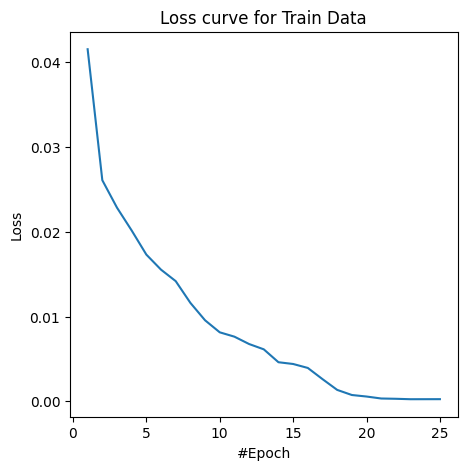

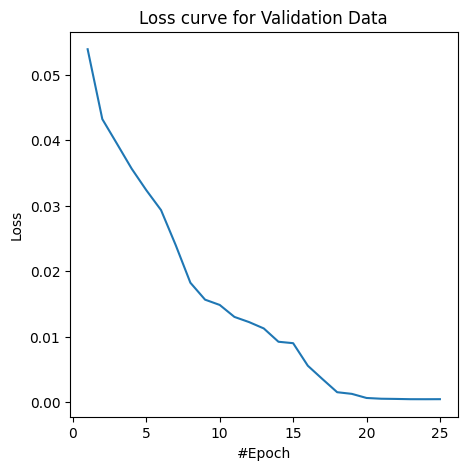

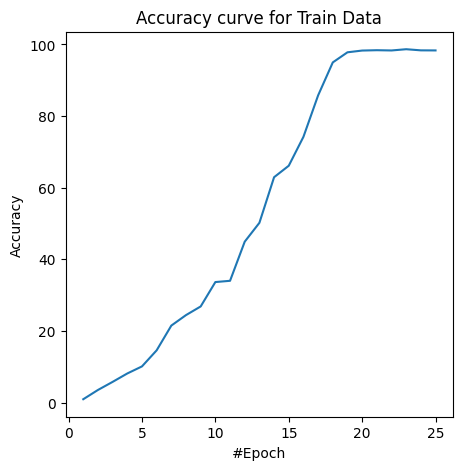

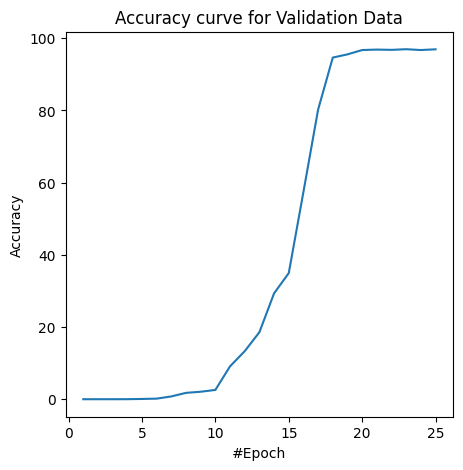

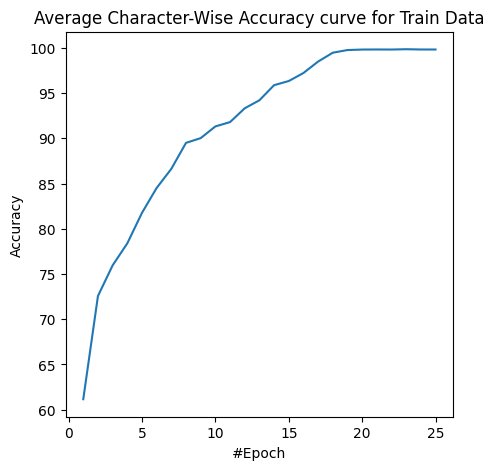

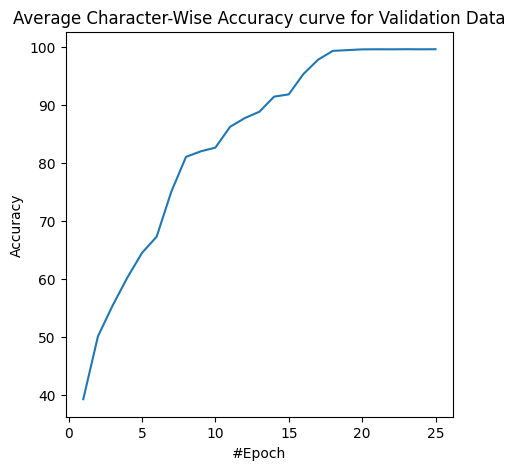

In [36]:
plt.rcParams["figure.figsize"] = (5,5)
for i in range(6):
    model_normal.plot_loss_curve(i)

In [37]:
model_normal.predict(test_data_loader)

Accuracy on Test Data =  96.6900  %
Charwise Accuracy on Test Data =  99.6050  %
Character-wise Accuracy:
[0.9947, 0.9699001, 0.99969995, 0.99719995, 1.0, 1.0, 0.9994, 1.0, 1.0, 0.9996]


In [38]:
# Checking wrongly predicted dates in validation dataset
# val_data_loader_bs1 = DataLoader(valid_data, batch_size = 1)
# model_normal.check_wrong_dates(test_data_loader)

# Using Attention Mechanism

In [39]:
# specify model parameters and train
n_epochs =  30
lr = 0.005
model_attention = seq_to_seq(encoder_input_size = train_X.shape[2], decoder_input_size = train_y.shape[2], hidden_size = 200, decoder_output_size = output_vocab_size, input_len = train_X.shape[1], is_attention = True).to(device)
model_attention.fit(train_data_loader, valid_data_loader, n_epochs = n_epochs, target_len = train_y.shape[1], batch_size = batch_size, teacher_forcing_ratio = 0.5, learning_rate = lr)

 Epoch Number =  0 
Training Loss =  0.0491 ; Validation Loss =  0.0502
Train Accuracy =  0.0531 %; Validation Accuracy =  0.0000 %
Train Charwise Accuracy =  50.2644 %;  ; Validation Charwise Accuracy =  42.5887 %
 Epoch Number =  1 
Training Loss =  0.0270 ; Validation Loss =  0.0387
Train Accuracy =  2.7125 %; Validation Accuracy =  0.0625 %
Train Charwise Accuracy =  74.1581 %;  ; Validation Charwise Accuracy =  59.0675 %
 Epoch Number =  2 
Training Loss =  0.0212 ; Validation Loss =  0.0301
Train Accuracy =  8.9313 %; Validation Accuracy =  1.0750 %
Train Charwise Accuracy =  80.7581 %;  ; Validation Charwise Accuracy =  71.4075 %
 Epoch Number =  3 
Training Loss =  0.0147 ; Validation Loss =  0.0211
Train Accuracy =  26.0312 %; Validation Accuracy =  13.4875 %
Train Charwise Accuracy =  87.7950 %;  ; Validation Charwise Accuracy =  82.7200 %
 Epoch Number =  4 
Training Loss =  0.0089 ; Validation Loss =  0.0092
Train Accuracy =  55.9656 %; Validation Accuracy =  61.5250 %
Trai

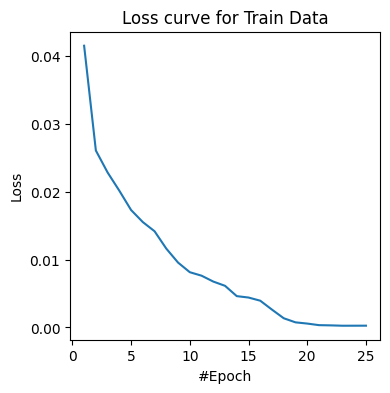

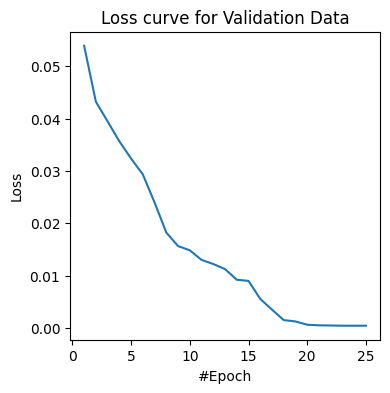

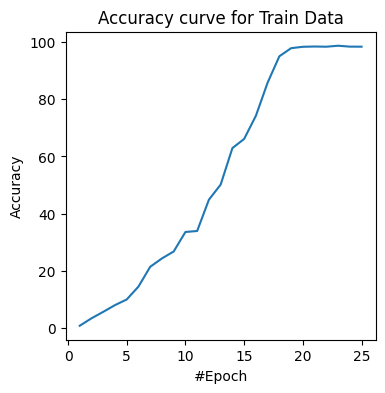

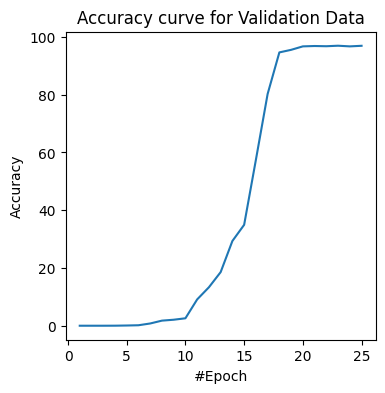

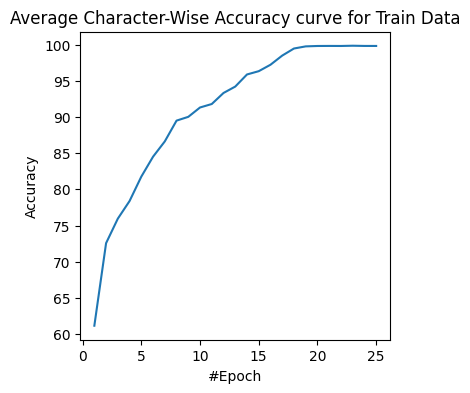

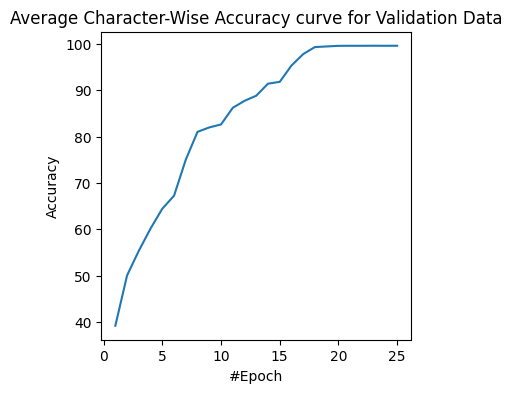

In [40]:
plt.rcParams["figure.figsize"] = (4,4)
for i in range(6):
    model_normal.plot_loss_curve(i)

In [41]:
model_attention.predict(test_data_loader)

Accuracy on Test Data =  96.6100  %
Charwise Accuracy on Test Data =  99.6040  %
Character-wise Accuracy:
[0.9947, 0.96910006, 0.99959993, 0.99709994, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999]


In [42]:
# Checking wrongly predicted dates in validation dataset
# val_data_loader_bs1 = DataLoader(valid_data, batch_size = 1)
# model_attention.check_wrong_dates(test_data_loader)

torch.Size([1, 17, 34])
torch.Size([1, 12, 13])
(12,)
19 feb 2020 -> 2020-02-19


/tmp/ipykernel_3193113/2529251557.py:97: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  decoder_input = torch.FloatTensor([output_hardmax_dict[SOS] for i in range(batch_size)]).to(device)


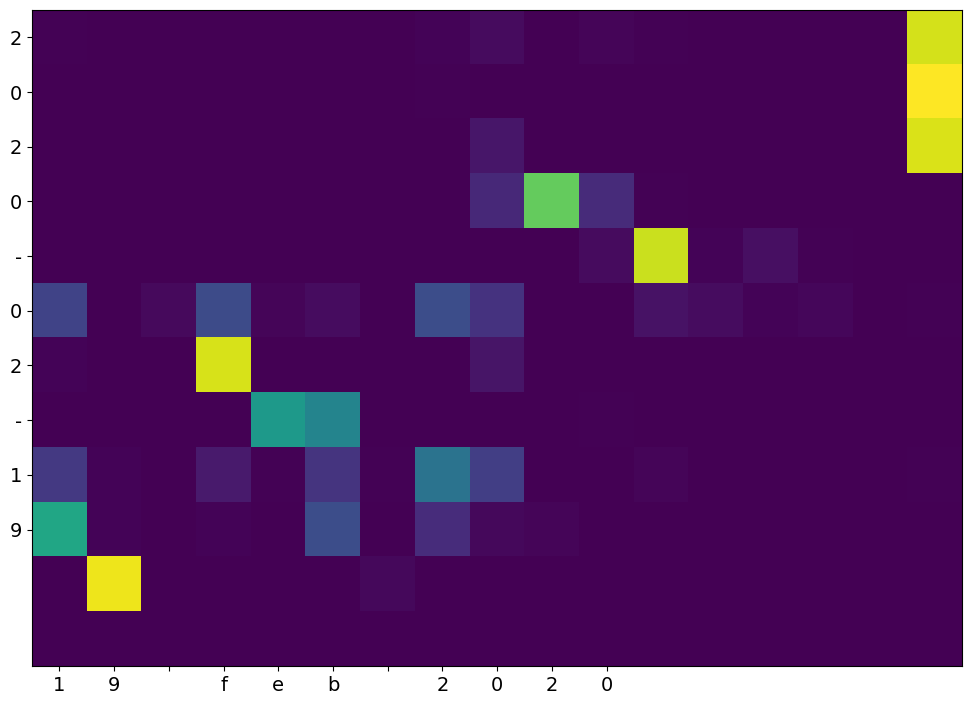

In [43]:
plt.rcParams["figure.figsize"] = (12,12)
model_attention.visualize("19 feb 2020")

# Conclusion

1. MSELoss works but CrossEntropy doesn't, reason?? Logic says that CE should also work as it is a classification task.
2. Adam works but SGD doesn't. This is because, SGD is not able to move through the plateau region while Adam moves quicly throgh plateau.
3. SOS and EOS are important!